In [2]:
import qiskit
import numpy as np
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.encoding
import importlib
importlib.reload(qtm.base)
importlib.reload(qtm.constant)
importlib.reload(qtm.onequbit)
importlib.reload(qtm.nqubit)
importlib.reload(qtm.fubini_study)

<module 'qtm.fubini_study' from '..\\qtm\\fubini_study.py'>

20/12/2021

In this notebook I will conduct the experiments about tomography.

With $U_{gen} = $ Haar random

And $U_{target} = W + ZXZ, W = W_{chain}, W_{all to all}, W_{alternating}$

### 1. W_{chain}

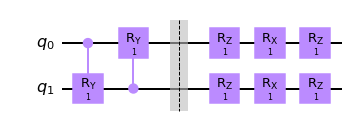

In [3]:
num_qubits = 2
num_layers = 1
thetas = np.ones(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')

qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers=num_layers)
qc.draw('mpl')

In [4]:
num_qubits = 4
num_layers = 2
thetas = np.ones(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []

# qc = encoder.qcircuit
# qc = qtm.nqubit.create_Wchainchecker_haar(qc, thetas, num_layers)

for i in range(0, 300):
    if i % 20 == 0:
        print('W_chain: ', i)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchainchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Wchainchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_chain:  0
W_chain:  20
W_chain:  40
W_chain:  60
W_chain:  80
W_chain:  100
W_chain:  120
W_chain:  140
W_chain:  160
W_chain:  180
W_chain:  200
W_chain:  220
W_chain:  240
W_chain:  260


In [45]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))

np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/loss_values.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/thetass.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/traces.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/fidelities.csv", fidelities, delimiter=",")

Writting ... 3


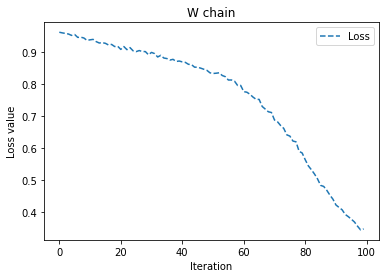

In [3]:
from matplotlib import pyplot as plt
# plt.plot(fidelities, label='Fidelity', linestyle = '-')
# plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W chain')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 

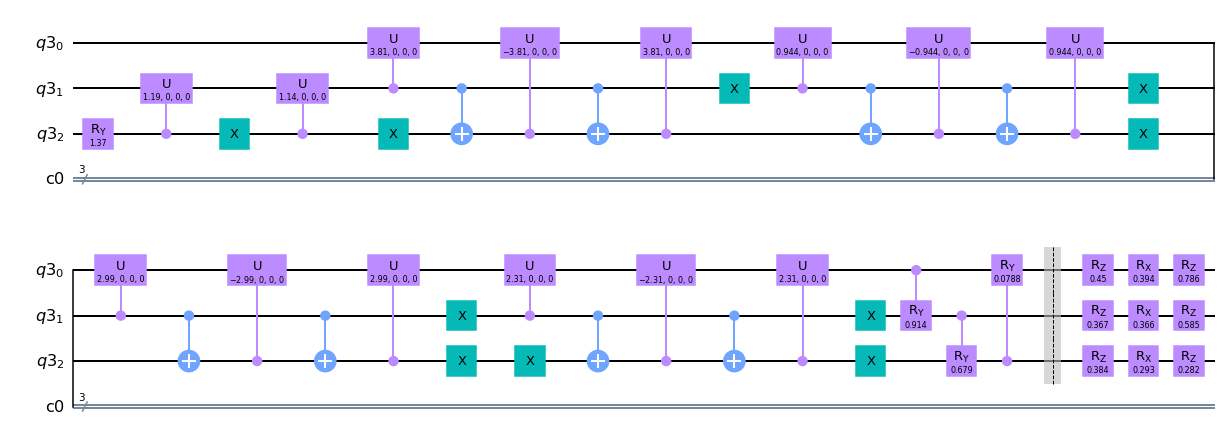

In [5]:
num_qubits = 3
num_layers = 1
thetas = np.random.random(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = encoder.qcircuit
qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers=num_layers)
qc.add_register(qiskit.ClassicalRegister(encoder.num_qubits))
qc.draw('mpl')

### 2. W alternating

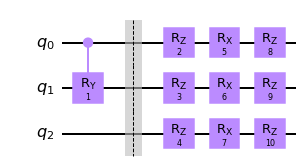

In [7]:
num_qubits = 3
num_layers = 1
n_alternating = 0
for i in range(0, num_layers + 1):
    n_alternating += qtm.nqubit.calculate_n_walternating(i, num_qubits)
thetas = np.ones(n_alternating + 3 * num_layers * num_qubits)

for i in range(0, len(thetas)):
    thetas[i] += i

psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walternating_layerd_state(qc,
                                                 thetas,
                                                 num_layers=num_layers)
qc.draw('mpl')


In [125]:
num_qubits = 3
num_layers = 1
n_alternating = 0
for i in range(0, num_layers + 1):
    n_alternating += qtm.nqubit.calculate_n_walternating(i, num_qubits)
thetas = np.ones(n_alternating + 3 * num_layers * num_qubits)

for i in range(0, len(thetas)):
    thetas[i] += i

psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []
for i in range(0, 400):
    if i % 20 == 0:
        print('W_alternating: ', i)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Walternatingchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Walternatingchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_alternating:  0
W_alternating:  20
W_alternating:  40
W_alternating:  60
W_alternating:  80
W_alternating:  100
W_alternating:  120
W_alternating:  140
W_alternating:  160
W_alternating:  180


In [127]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Walternating_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))

np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/loss_values.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/thetass.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/traces.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/fidelities.csv", fidelities, delimiter=",")

Writting ... 3


C:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


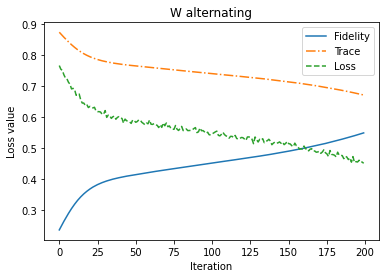

In [128]:
from matplotlib import pyplot as plt
plt.plot(fidelities, label='Fidelity', linestyle = '-')
plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W alternating')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 


### 3. W all to all

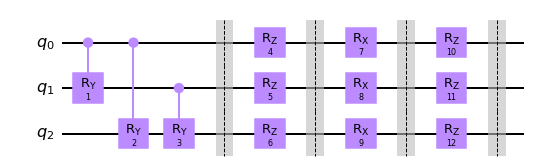

In [6]:
num_qubits = 3
num_layers = 1
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
thetas = np.ones(num_layers* 3 * num_qubits + num_layers*n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walltoall_layerd_state(qc, thetas, num_layers=num_layers)
qc.draw('mpl')


In [7]:
num_qubits = 3
num_layers = 1
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
thetas = np.ones(num_layers* 3 * num_qubits + num_layers*n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []
for i in range(0, 200):
    if i % 20 == 0:
        print('W_chain: ', i)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Walltoallchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Walltoallchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_chain:  0
[ 2.57079633  2.          3.          4.          5.          6.
  7.          8.          9.         10.         11.         12.        ]
[-0.57079633  2.          3.          4.          5.          6.
  7.          8.          9.         10.         11.         12.        ]
[ 1.          3.57079633  3.          4.          5.          6.
  7.          8.          9.         10.         11.         12.        ]
[ 1.          0.42920367  3.          4.          5.          6.
  7.          8.          9.         10.         11.         12.        ]
[ 1.          2.          4.57079633  4.          5.          6.
  7.          8.          9.         10.         11.         12.        ]
[ 1.          2.          1.42920367  4.          5.          6.
  7.          8.          9.         10.         11.         12.        ]
[ 1.          2.          3.          5.57079633  5.          6.
  7.          8.          9.         10.         11.         12.        ]
[ 1.          2

In [8]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Walltoall_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))


np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/loss_values.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/thetass.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/traces.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_" + str(num_layers) + '/' + str(num_qubits) + "/fidelities.csv", fidelities, delimiter=",")

[ 1.00073  1.99302  2.96519  4.01974  4.99211  6.00179  6.99915  7.97737
  9.01095  9.99985 10.99923 11.99976]
[ 1.00098  1.98482  2.93065  4.0403   4.98459  6.00379  6.99931  7.95654
  9.02339 10.00047 10.99844 12.00036]
[ 1.00174  1.97823  2.89641  4.06043  4.97788  6.00722  6.9993   7.93596
  9.03577 10.00152 10.99913 12.00029]
[ 1.00121  1.96958  2.86284  4.08165  4.97064  6.01021  7.00162  7.91645
  9.04921 10.00157 11.00034 12.00022]
[ 1.00151  1.96285  2.82858  4.10197  4.96228  6.01299  7.00492  7.89713
  9.06243 10.00119 10.99912 11.99966]
[ 1.00116  1.95654  2.79474  4.12226  4.95497  6.01505  7.00941  7.87921
  9.07486  9.9999  11.00032 11.99743]
[ 1.00052  1.94846  2.76138  4.14106  4.94727  6.01784  7.01558  7.86091
  9.08838 10.00021 10.99998 11.99703]
[ 0.99809  1.94136  2.72752  4.16216  4.93856  6.02235  7.02235  7.84426
  9.10349  9.99886 11.00018 11.99805]
[ 0.99666  1.93403  2.69431  4.18204  4.93119  6.02593  7.0288   7.82805
  9.11741  9.99875 11.00166 11.99752]
[

C:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


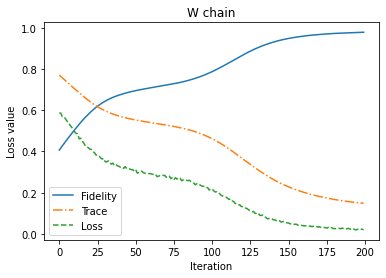

In [9]:
from matplotlib import pyplot as plt
plt.plot(fidelities, label='Fidelity', linestyle = '-')
plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W chain')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 
